"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [436]:
import pymc3 as pm
import theano
import theano.tensor as tt
import numpy as np
import pylab as plt
from scipy.stats import poisson

In [460]:
def var_sig_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-b*x))

def var_sig_exp_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-np.exp(b)*x))


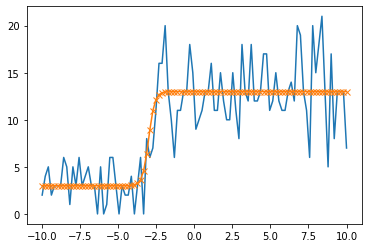

In [699]:
b = 5
inflect = -3
min_val = 3
scale = 10
x = np.linspace(-10,10,100)
rate = min_val + var_sig_np(x-inflect,b)*scale
y = poisson.rvs(rate)
plt.plot(x,y)
plt.plot(x,rate,'-x')

In [700]:
def var_sig_exp_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-tt.exp(b)*x))

def var_sig_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-b*x))

In [701]:
idx = np.arange(len(y))

with pm.Model() as model:
  
    a_tau = pm.Gamma('a_tau', alpha = 0.1, beta = 0.5)
    b_tau = pm.Gamma('b_tau', alpha = 0.1, beta = 0.5)
    tau_latent = pm.Beta('tau_latent', a_tau, b_tau)#, testval = 0.5)
    #tau_latent = pm.Beta('tau_latent', 2, 5, testval = 0.5)
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    min_val = pm.HalfNormal('min_val', 10)
    scale = pm.HalfNormal('scale', 10)
    
    
    #sig_b = pm.HalfCauchy('sig_b', 0.01)
    #lambda_ = pm.Deterministic('lambda_', min_val + var_sig_tt(idx-tau,sig_b)*scale)
    
    mu_sig = pm.Normal('mu_sig', -5,0.1)
    #sig_sig = pm.Gamma('sig_sig', mu = 7, sigma = 0.5)
    sig_b = pm.Normal('sig_b', mu_sig, 1)#sig_sig)
    #sig_b = pm.Normal('sig_b', -1, 0.1)
    lambda_ = pm.Deterministic('lambda_', min_val + var_sig_exp_tt(idx-tau,sig_b)*scale)

    
    # Add observations
    observation = pm.Poisson("obs", mu = lambda_, observed=y)

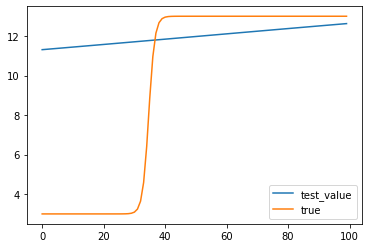

In [702]:
plt.plot(lambda_.tag.test_value,label='test_value')
plt.plot(rate,label='true')
plt.legend()

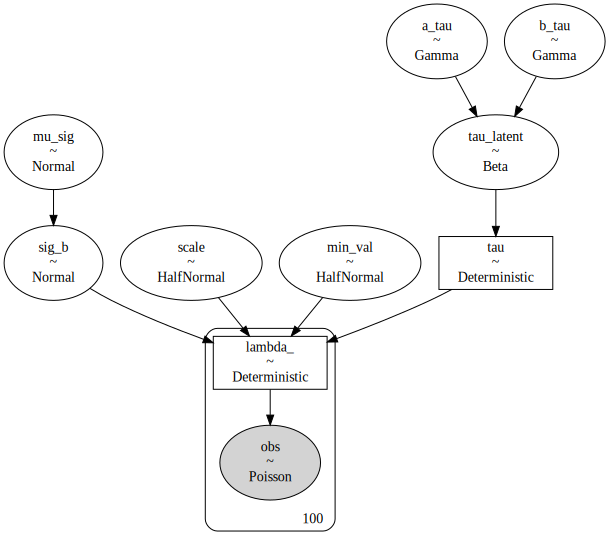

In [703]:
pm.model_to_graphviz(model)

In [704]:
with model:
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=0)

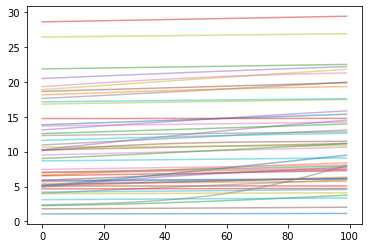

In [705]:
plt.plot(prior_checks['lambda_'].T, alpha = 0.5);

In [706]:
with model:
    inference = pm.ADVI('full-rank')
    tracker = pm.callbacks.Tracker(
            mean=inference.approx.mean.eval,  # callable that returns mean
            std=inference.approx.std.eval,  # callable that returns std
        )
    approx = pm.fit(n=100000, method=inference,
                   callbacks=[tracker])
    trace = approx.sample(draws=2000)

Finished [100%]: Average Loss = 274.02


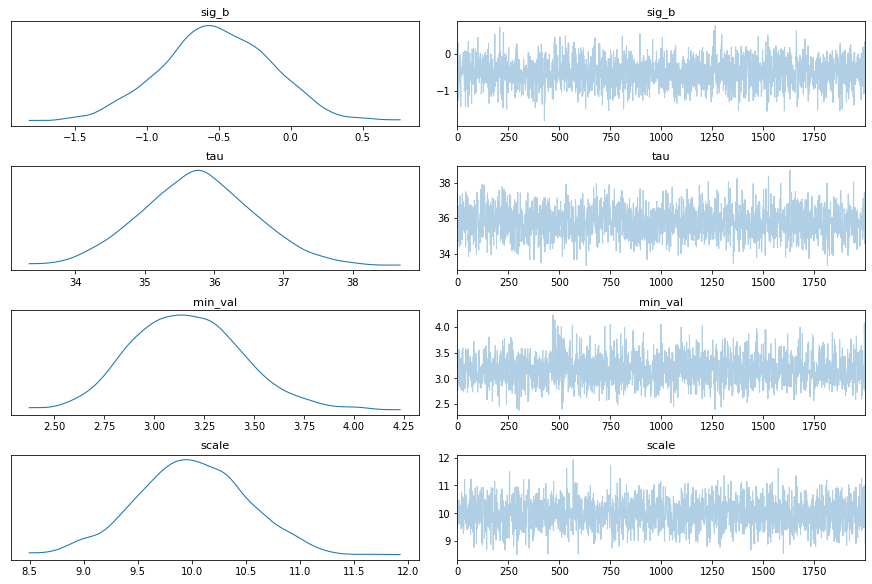

In [707]:
with model:
    pm.traceplot(trace, var_names = ['sig_b','tau', 'min_val','scale']);

In [708]:
def tracker_names_out(model):
    raw_rvs = model.free_RVs
    names = [x.name for x in raw_rvs]
    sizes = [x.tag.test_value.shape for x in raw_rvs]
    fin_sizes = [x[0] if x is not () else 1 for x in sizes]
    fin_names = [[this_name]*this_size for this_name, this_size in zip(names,fin_sizes)]
    fin_names = [x for y in fin_names for x in y]
    return fin_names

In [709]:
rv_names = tracker_names_out(model)
rv_names

['a_tau_log__',
 'b_tau_log__',
 'tau_latent_logodds__',
 'min_val_log__',
 'scale_log__',
 'mu_sig',
 'sig_b']

In [710]:
tracker_mean = np.stack(tracker['mean'])
tracker_std = np.stack(tracker['std'])

In [711]:
tracker_mean[-1]

array([ 2.29973275, -0.57048622,  1.14877037, -4.95867245, -0.51722976,
       -0.82768038, -1.12082121])

In [712]:
tracker_std[-1]

array([0.05106659, 0.03589252, 0.08854786, 0.10961249, 0.36951781,
       1.35990073, 1.28238566])

In [713]:
x = np.linspace(-3,3)
outs = np.stack([var_sig_exp_np(x,b) for b in np.exp(tracker_mean[:,0])])

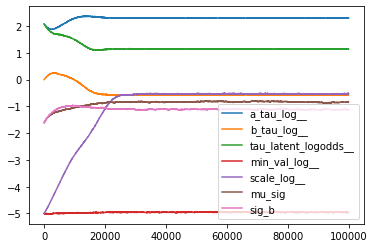

In [714]:
lineObjects = plt.plot(tracker_mean)
plt.legend(iter(lineObjects), rv_names)

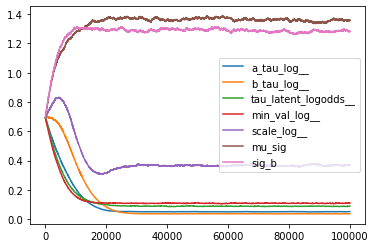

In [715]:
lineObjects = plt.plot(tracker_std)
plt.legend(iter(lineObjects), rv_names)

-0.514461903700196

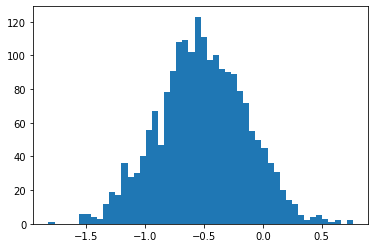

In [716]:
plt.hist(trace['sig_b'],50);
np.mean(trace['sig_b'])

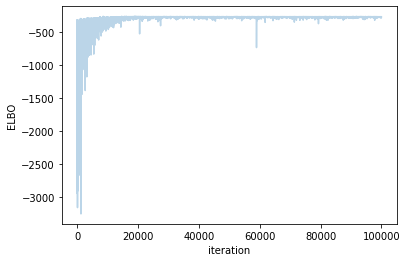

In [717]:
plt.plot(-approx.hist, alpha=.3)
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [718]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

In [719]:
tau = trace['tau']

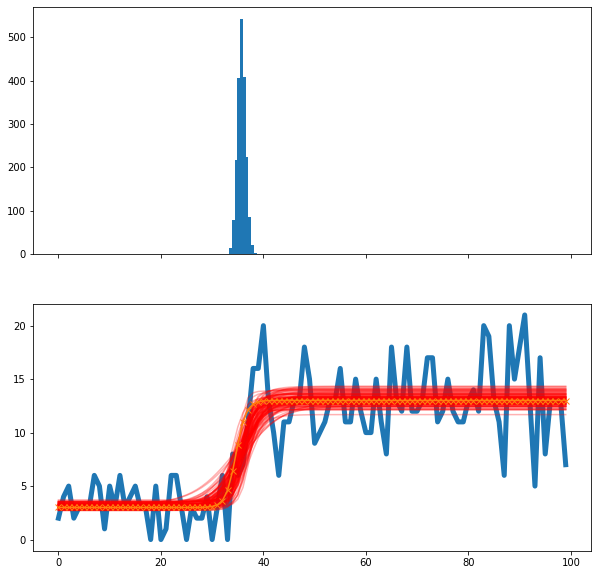

In [721]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].hist(tau)
ax[1].plot(y, linewidth = 5)
ax[1].plot(trace['lambda_'][:100].T,color='red', alpha = 0.3);
ax[1].plot(rate,'-x')
